(99788, 2) shape, shape
(100, 2) (100,)
             precision    recall  f1-score   support

          0       0.87      0.88      0.87        51
          1       0.88      0.86      0.87        49

avg / total       0.87      0.87      0.87       100

5
200
(2, 5)
(99788, 2) shape, shape
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        52
          1       0.96      0.96      0.96        48

avg / total       0.96      0.96      0.96       100



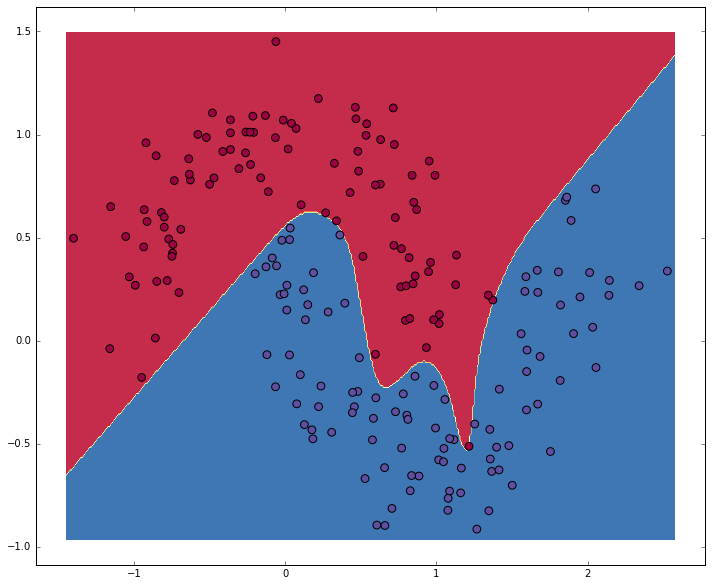

In [127]:
#############################################
#
#分类算法基础，线性模型
#############################################

#generate dataset and plot it
import sklearn
import numpy as np
from sklearn import datasets, linear_model,metrics
import matplotlib.pyplot as plt

#set the size of image
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 10

np.random.seed(0)
X,y = sklearn.datasets.make_moons(300, noise=0.2)
#测试数据集合
testX = X[200:,:]
testY = y[200:]

#训练数据集合
X = X[0:200, :]
y = y[0:200]
#plt.scatter(X[:,0], X[:,1], s=60, c= y, cmap=plt.cm.Spectral)

#BUILD A CLASSIFIER
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

#plot decision boundary
def plot_decision_boundary( predict_func, X, y):
    #set max min of x,y axis
    x_min, x_max = X[:,0].min()-0.05, X[:,0].max() + 0.05
    y_min, y_max = X[:,1].min()-0.05, X[:,1].max() + 0.05
    h = 0.01
    #make grid
    #xx 每行穷举了所有的xx的可能的值，假设xx有n种可能
    #yy 每行对应一个y值， y有m种可能
    ##shape 是 m * n
    xx, yy = np.meshgrid( np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #生产 （x,y)坐标
    x_y = np.c_[xx.ravel(), yy.ravel()]
    print x_y.shape, "shape, shape"
    #预测
    Z = predict_func(x_y)
    Z = Z.reshape(xx.shape)
    #画等高线
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], s=60, c=y, cmap = plt.cm.Spectral)
    
plot_decision_boundary(clf.predict, X, y)

#评价函数性能
print testX.shape, testY.shape
print metrics.classification_report( clf.predict(testX), testY)



############################################################
#
#  神经网络相关的算法
#############################################################
#全局信息
nn_input_dim = 2
nn_output_dim = 2
nn_hdim = 5 #隐含层个数
num_pass = 20000 #训练次数
print_loss = False #是否打印训练过程中的损失函数的大小
epsilon = 0.01 # 学习速率
reg_lambda = 0.01 #正则化权重
model = {} #模型
#np.sum 的理解axis = 1 的情况，sum是将每行相加


#calculate loss

def calculate_loss(X, y):
    num_examples = len(X)
    W1,b1,W2,b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp( z2 )
    probs = exp_scores / np.sum( exp_scores, axis=1, keepdims=True)
    #loss function: sum of correct log_probs
    correct_logprobs = -np.log( probs [ range ( num_examples), y] )
    data_loss = np.sum( correct_logprobs )
    #add regularization
    data_loss += reg_lambda *1./2 * ( np.sum( np.square( W1 )) + np.sum( np.square( W2 )))
    return 1. / num_examples * data_loss
    pass


def predict(x):
    W1,b1,W2,b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp( z2 )
    probs = exp_scores / np.sum( exp_scores, axis=1, keepdims=True)
    return np.argmax( probs, axis=1)


def train(X, y):
    #初始化
    num_examples = len( X )
    np.random.seed(0)
    W1 = np.random.randn( nn_input_dim, nn_hdim )/np.sqrt( nn_input_dim )
    print nn_hdim
    b1 = np.zeros( (1, nn_hdim) )
    W2 = np.random.randn( nn_hdim, nn_output_dim)/np.sqrt( nn_hdim )
    b2 = np.zeros( (1, nn_output_dim) )
    global model
    model [ 'W1' ] = W1
    model [ 'b1' ] = b1
    model [ 'W2' ] = W2
    model [ 'b2' ] = b2
    print num_examples
    
    for i in xrange( 0, num_pass):
        #Forword propagation
        z1 = X.dot(W1) + b1  #num_examples * hidden_dim
        a1 = np.tanh( z1 )   #num_examples * hidden_dim
        z2 = a1.dot( W2 ) + b2 #num_examples * output_dim
        exp_scores = np.exp(z2)
        probs = exp_scores /np.sum( exp_scores, axis=1, keepdims=True)
        
        #Back propagation
        delta3 = probs   #num_examples * output_dim
        delta3 [range( num_examples), y] -= 1
        dW2 = (a1.T).dot( delta3)  #hidden_dim * output_dim
        db2 = np.sum( delta3, axis=0, keepdims=True) #1 * output_dim
        delta2 = delta3.dot( W2.T) * ( 1 - np.power(a1, 2)) #num_examples * hidden_dim
        db1 = np.sum( delta2, axis=0, keepdims=True) # 1 * hidden_dim
        dW1 = (X.T).dot(delta2)#input_dim * hidden_dim
        
        W1 -= epsilon * dW1
        W2 -= epsilon * dW2
        b1 -= epsilon * db1
        b2 -= epsilon * db2
        model = {"W1": W1, "W2": W2, "b1": b1, "b2": b2}
        
        if print_loss and i % 1000 == 0:
            print ( "Loss after iteration %i : %.4f"%  ( i, calculate_loss( X, y)))
        
        

#########################
#神经网络主程序
#########################
model = {}
train(X, y)
print model['W1'].shape
plot_decision_boundary(predict, X, y)

print metrics.classification_report( predict(testX), testY)

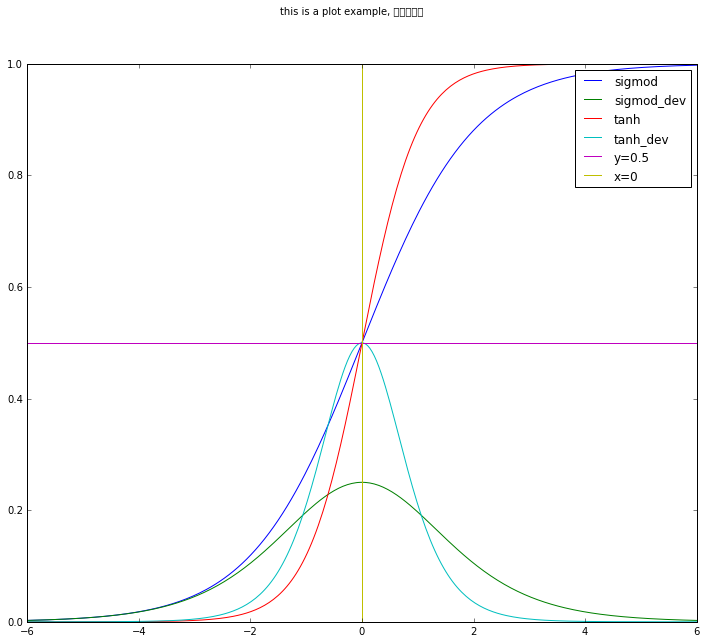

In [100]:
#绘制sigmod 函数
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace( -6, 6, 300)
#sigmod 函数
sigmod_plot,= plt.plot(x, 1./ ( 1 + np.exp(-1 * x)))
sigmod_dev_plot, = plt.plot(x, 1./( 1 + np.exp( -1 * x) ) * ( 1- 1./( 1 + np.exp( -1 * x))))

#tanx 函数
tanh_plot, = plt.plot(x, (1 + np.tanh(x) )/2.)
tanh_dev_plot, = plt.plot(x,  0.5 * ( 1- np.tanh(x)* np.tanh(x)) )
#绘制横轴
y = np.array( [0.5] * x.size)
x_plot,= plt.plot(x, y)
#绘制纵轴
x = [0] * 300
y = np.linspace(0,1, 300)
y_plot, = plt.plot(x, y)
#添加legend
plt.legend([sigmod_plot, sigmod_dev_plot ,tanh_plot,tanh_dev_plot, x_plot, y_plot], ( "sigmod", "sigmod_dev", "tanh",\
                                                                                 "tanh_dev",\
                                                                                 "y=0.5", "x=0") )
#添加title
plt.suptitle("this is a plot example, 不支持中文".decode("utf-8")) #这里不支持中文
plt.show()

In [ ]:
#实现一个神经网络模型
